In [4]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,make_scorer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import metrics
from math import log

sbn.set()

def get_diff_month(d1,d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month




In [5]:
df = pd.read_csv('./data/properties_2017.csv',low_memory=False)
original = df.copy()

# train = pd.read_csv('./data/train_2016_v2.csv')

## Dataset Description

The shape of the dataset provided is  (2985217, 58).

The following are the different features of real estate properties that are provided to us: 
1. parcelid
2. airconditioningtypeid
3. architecturalstyletypeid
4. basementsqft
5. bathroomcnt
6. bedroomcnt
7. buildingclasstypeid
8. buildingqualitytypeid
9. calculatedbathnbr
10. decktypeid
11. finishedfloor1squarefeet
12. calculatedfinishedsquarefeet
13. finishedsquarefeet12
14. finishedsquarefeet13
15. finishedsquarefeet15
16. finishedsquarefeet50
17. finishedsquarefeet6
18. fips
19. fireplacecnt
20. fullbathcnt
21. garagecarcnt
22. garagetotalsqft
23. hashottuborspa
24. heatingorsystemtypeid
25. latitude
26. longitude
27. lotsizesquarefeet
28. poolcnt
29. poolsizesum
30. pooltypeid10
31. pooltypeid2
32. pooltypeid7
33. propertycountylandusecode
34. propertylandusetypeid
35. propertyzoningdesc
36. rawcensustractandblock
37. regionidcity
38. regionidcounty
39. regionidneighborhood
40. regionidzip
41. roomcnt
42. storytypeid
43. threequarterbathnbr
44. typeconstructiontypeid
45. unitcnt
46. yardbuildingsqft17
47. yardbuildingsqft26
48. yearbuilt
49. numberofstories
50. fireplaceflag
51. structuretaxvaluedollarcnt
52. taxvaluedollarcnt
53. assessmentyear
54. landtaxvaluedollarcnt
55. taxamount
56. taxdelinquencyflag
57. taxdelinquencyyear
58. censustractandblock

#### The training data has  90275  rows with logerror specified for a parcelid and a transaction date

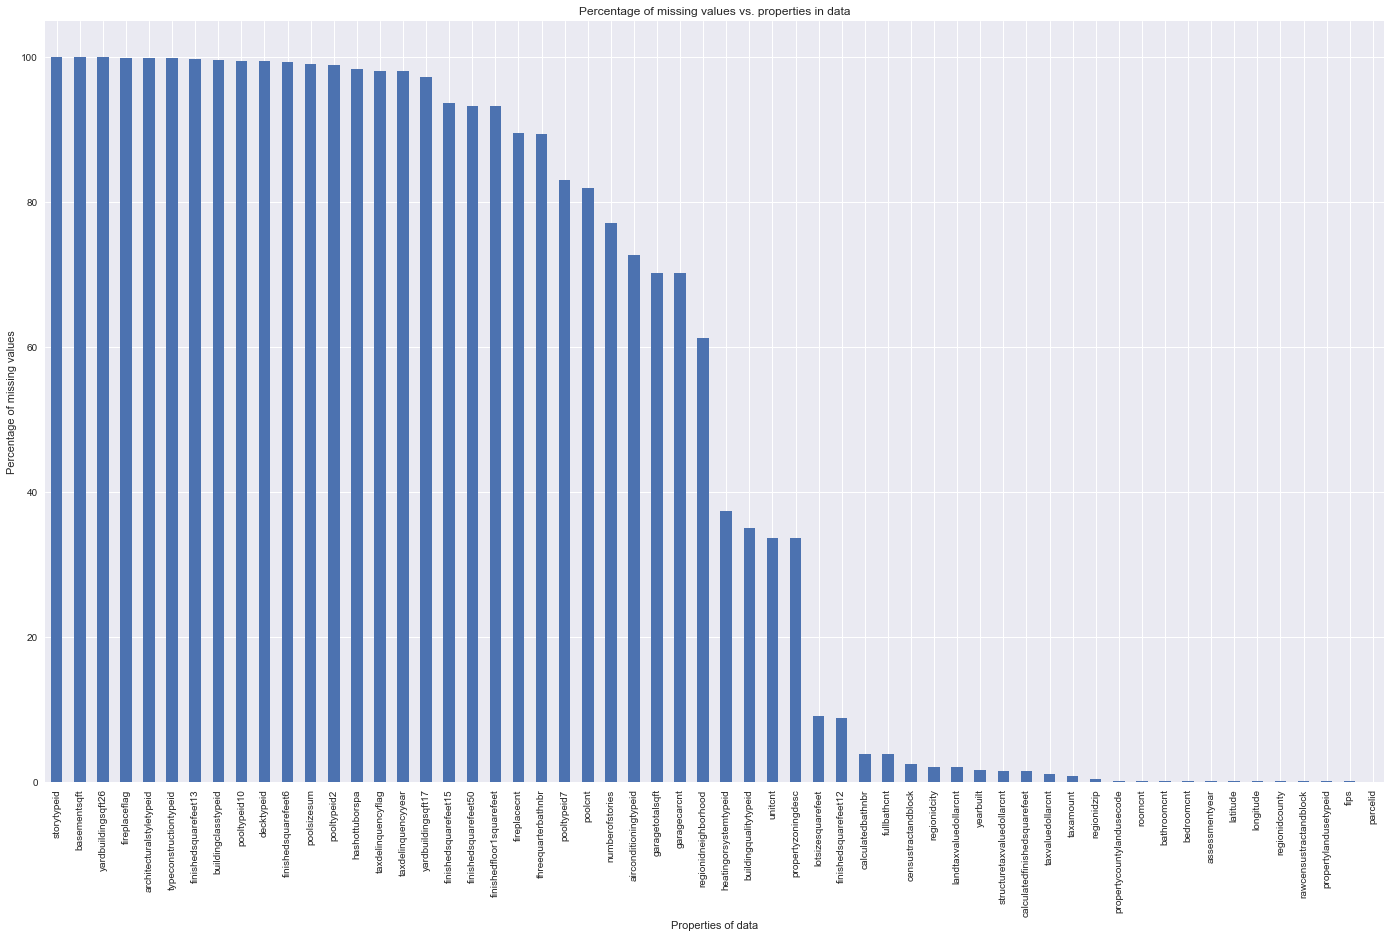

In [3]:
missing_data = original.isnull().sum()
missing_data.sort_values(0,ascending=False,inplace = True)
missing_data = missing_data/(len(original))*100


# missing_data
missing_plot = missing_data.plot.bar(figsize= (24,14))
plt.title('Percentage of missing values vs. properties in data')
plt.xlabel('Properties of data')
plt.ylabel('Percentage of missing values')
plt.savefig('percent.pdf')
plt.show()
del missing_plot
del missing_data

In [ ]:
# df = original.copy()

In [9]:
df['yardbuildingsqft17'].fillna(0, inplace = True)
df['unitcnt'].fillna(1, inplace = True)
df['garagetotalsqft'].fillna(0, inplace = True)
df['fireplacecnt'].fillna(0, inplace = True)
df['hashottuborspa'].fillna(0, inplace = True)
df['yearbuilt'].fillna(df['yearbuilt'].median(), inplace = True)
df['buildingqualitytypeid'].fillna(7, inplace = True) #df['buildingqualitytypeid'].mode() results to 7
df['bedroomcnt'].fillna(df['bedroomcnt'].median(), inplace = True)
df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].median(), inplace = True)
df['poolcnt'].fillna(0,inplace = True)
df['calculatedbathnbr'].fillna(df['calculatedbathnbr'].median(),inplace = True)
df['airconditioningtypeid'].fillna(-1,inplace=True)  #earlier it was replaced with 0,now replacing it with -1
df['propertylandusetypeid'].fillna(df['propertylandusetypeid'].mode(),inplace=True)
df['regionidcity'].fillna(df['regionidcity'].mean(),inplace=True) #mean is meaningless, but still
df['taxdelinquencyflag'].fillna(0,inplace=True)
df['taxdelinquencyflag'] =  df['taxdelinquencyflag'].map({'Y':1,0:0})
df['garagecarcnt'].fillna(0,inplace=True)
df['taxdelinquencyyear'] = pd.Series([15-i if i<16 else 115-i for i in df['taxdelinquencyyear']]).fillna(-1)
df['heatingorsystemtypeid'].fillna(2,inplace=True) # df['heatingorsystemtypeid'].mode() results in 2
df['actual_area'] = df[['finishedfloor1squarefeet','calculatedfinishedsquarefeet','finishedsquarefeet12', 'finishedsquarefeet13',
                        'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6']].max(axis=1)


df['fips'].fillna(df['fips'].median(),inplace = True)
df['latitude'].fillna(df['latitude'].median(),inplace = True)
df['longitude'].fillna(df['longitude'].median(),inplace = True)
df['regionidcounty'].fillna(df['regionidcounty'].median(),inplace = True)
df['regionidzip'].fillna(df['regionidzip'].median(),inplace = True)

df['actual_area'].replace(to_replace=1.0,value=np.nan,inplace=True)
df['actual_area'].fillna(df['actual_area'].median(),inplace=True)


df['hashottuborspa'] = df['hashottuborspa'].map({True:1,0:0})

df['calculatedvalue'] = df[['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']].sum(axis=1)

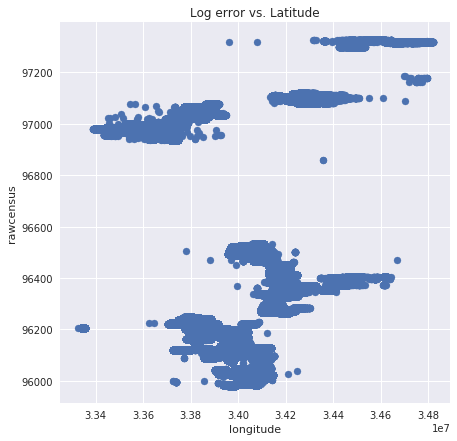

In [20]:
# print df['rawcensustractandblock'].describe()
plt.figure(figsize=(7,7))
regzip = df[df['regionidzip'] <  df['regionidzip'].quantile(0.995)]

plt.scatter(regzip.latitude,regzip.regionidzip)
plt.xlabel('longitude')
plt.ylabel('rawcensus')
plt.title("Log error vs. Latitude")
plt.show()

In [5]:
age = []
for i in df['yearbuilt']:
    age.append(int(2015-i))

df['age'] = age
df.drop(['yearbuilt'],axis=1,inplace=True)

In [7]:
before_rogue = df.copy()

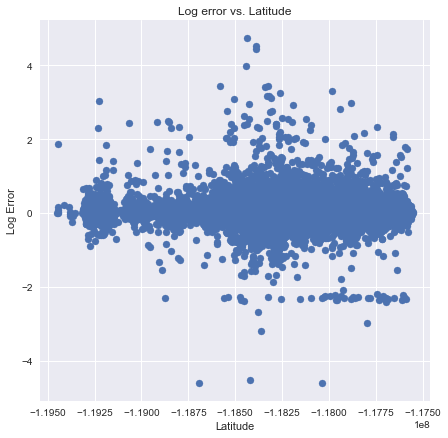

In [11]:
# plt.scatter(logplot.index,logplot.logerror)
plt.figure(figsize=(7,7))
plt.scatter(merged.longitude,merged.logerror)
plt.xlabel('Latitude')
plt.ylabel('Log Error')
plt.title("Log error vs. Latitude")
plt.show()

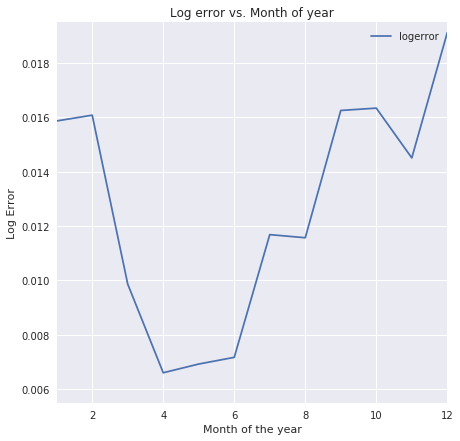

In [18]:
# month_v_error = merge_copy[['month_of_year','logerror']].plot.bar(figsize= (12,7))
month_v_error =  merged[['month_of_year','logerror']].groupby(by='month_of_year').mean().plot.line(figsize= (7,7),
                                                                                                   ylim =[0.0055,0.0195])
plt.title('Log error vs. Month of year')
plt.xlabel('Month of the year')
plt.ylabel('Log Error')
plt.show()

When we plot the month of the year against the mean logerror, we see that the value of the bar graph reduces in the months of March-June before rising up again in July. However, this is not to be intepreted as a reduction in the error, it only means that the mean is lower, the logerror could be negative. We will have to plot the month against the absolute error to see if their model is more accurate during the specified months or does it just give negative error.

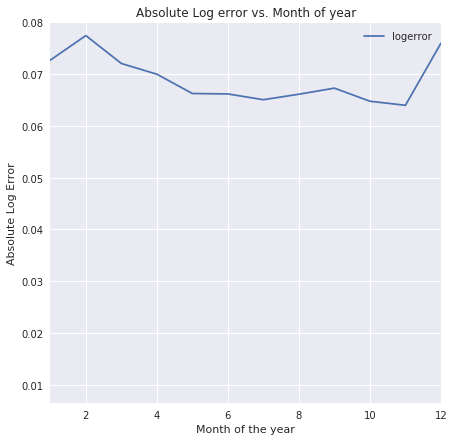

In [24]:
month_v_error = merged[['month_of_year','logerror']].copy()
month_v_error['logerror'] = abs(month_v_error['logerror'])
month_v_error1 =  month_v_error[['month_of_year','logerror']].groupby(by='month_of_year').mean().plot.line(figsize= (7,7),
                                                                                                           ylim = [0.0065,0.08])
plt.title('Absolute Log error vs. Month of year')
plt.xlabel('Month of the year')
plt.ylabel('Absolute Log Error')
plt.show()

As suspected, there is no correlation between the month of the year and the absolute value of logerror. We can still use the value of 'month_of_year' as a feature and see if it benefits the model in anyway.

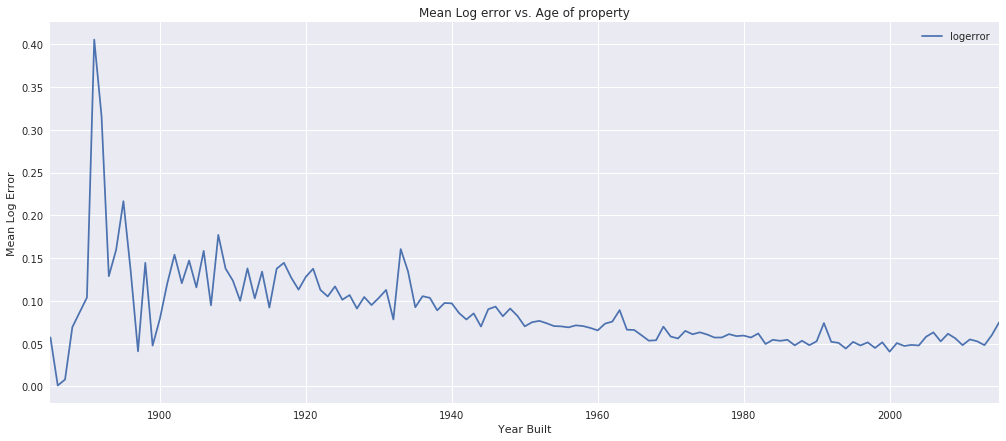

In [25]:
age_v_error = merged[['age','logerror']].copy()
age_v_error['age'] = [2015-i for i in age_v_error['age']]
age_v_error.loc[:,'logerror'] = abs(month_v_error['logerror'])
age_v_error1 =  age_v_error[['age','logerror']].groupby(by='age').mean().plot.line(figsize= (17,7))
plt.xlabel('Year Built')
plt.ylabel('Mean Log Error')
plt.title('Mean Log error vs. Age of property')
plt.show()

We can see that the mean absolute log error shows a reducing trend for properties that were more recently built when compared to the other older ones

In [29]:
clf = LinearRegression(n_jobs=-1,normalize=False)
clf.fit(X_train,y_train)

res = clf.predict(X_test)

print "The MAE is",mean_absolute_error(y_test,res),"and the MSE is",mean_squared_error(y_test,res)

The MAE is 0.057234063948 and the MSE is 0.00933196759458


After imputing missing values and selecting some columns that give us the best result, we again apply linear regression on the data. This time it performs much better and gives an **MAE and MSE of 0.05723 and 0.009327** respectively.

In [30]:
print pd.DataFrame({'columns': list(set(merged.keys()) - set(['logerror','parcelid'])),'coeffs': clf.coef_}) 

          coeffs                columns
0   2.098459e-05  airconditioningtypeid
1  -8.077620e-05        calculatedvalue
2   3.140129e-05              longitude
3  -6.950600e-04  buildingqualitytypeid
4   1.225584e-04                poolcnt
5  -1.758425e-03            actual_area
6  -2.770202e-06                    age
7  -8.292334e-03            regionidzip
8  -4.149567e-09      calculatedbathnbr
9   2.922476e-09          month_of_year
10  1.067703e-08                unitcnt
11 -7.089031e-03                   fips
12  1.623353e-06        garagetotalsqft
13 -3.423522e-08           fireplacecnt
14 -2.229684e-03         regionidcounty
15 -1.504435e-05               latitude
16  9.178209e-06        transactiondate
17 -3.440813e-09      lotsizesquarefeet
18 -2.438842e-05             bedroomcnt
19  2.602041e-04     yardbuildingsqft17
20  2.602041e-04         hashottuborspa


This information can be used to find out the most important and the weakest attributes that are used for linear regression

The best feature so far in the model is the regionidzip with the coefficient -8.292334e-03.

In [31]:
lasso = linear_model.Lasso(alpha = 0.0001,tol=0.000000001,max_iter=2147483647,warm_start = False,normalize=False)
lasso.fit(X_train,y_train)
print mean_squared_error(lasso.predict(X_test),y_test), mean_absolute_error(lasso.predict(X_test),y_test)

0.00933364574668 0.0572353990591


In [32]:
ridge = linear_model.Ridge(alpha = 2000,normalize=False, tol=0.000000001, max_iter=2147483647)
ridge.fit(X_train,y_train)
print mean_squared_error(ridge.predict(X_test),y_test),mean_absolute_error(ridge.predict(X_test),y_test)

0.00933427573712 0.0572385622896


In [33]:
svr = svm.LinearSVR(C=0.1, max_iter=20000, tol=1e-06)
svr.fit(sc_train,y_train)

LinearSVR(C=0.1, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=20000,
     random_state=None, tol=1e-06, verbose=0)

In [34]:
print mean_absolute_error(svr.predict(sc_test),y_test), mean_squared_error(svr.predict(sc_test),y_test)

0.0569388062164 0.00935902723606


LinearSVR has by far given us the **best result** of all the models that were trained. LinearSVR gives an **MAE and MSE of 0.05693 and 0.009327** respectively.

In [ ]:
# knr = KNR(n_jobs=-1)
# knr_param_grid = {
#     'n_neighbors' : [1800,2500,5000],
#     'leaf_size': [200,300,600],
#     'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    
    
# }
# knr_gcv = GridSearchCV(knr,knr_param_grid,scoring = make_scorer(mean_absolute_error,greater_is_better=False))

# knr_gcv.fit(sc_train,y_train)

# best = knr_gcv.best_estimator_

# print mean_squared_error(best.predict(s_test),y_test), best

The best estimator chosen by the GridSearch was

KNeighborsRegressor(algorithm='auto', leaf_size=300, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=1800, p=2,
          weights='uniform')


This gave us an **MAE of 0.057368**




In [ ]:
sub = pd.read_csv('./data/sample_submission.csv')

sub.rename(columns={'ParcelId':'parcelid'},inplace=True)
sub_oct = pd.merge(df.drop(['garagecarcnt','heatingorsystemtypeid','propertylandusetypeid','regionidcity',u'taxdelinquencyflag',
                            'taxdelinquencyyear'],axis=1),sub,on='parcelid')

sub_oct.reset_index(inplace=True)
sub_oct.drop(['201610','201611','201612','201710','201711','201712','parcelid',"index"],axis=1,inplace=True)
# sub_oct.info(null_counts=True)


sub_new_dec = sub_oct.copy()
sub_new_nov = sub_oct.copy()
sub_new_oct = sub_oct.copy()
sub_dec = sub_oct.copy()
sub_nov = sub_oct.copy()

sc.fit(merged.drop(['parcelid','logerror'],axis=1))
             
sub_oct['transactiondate'] = [22 for i in range(len(sub_oct))]
sub_oct['month_of_year'] = [10 for i in range(len(sub_oct))]
sub_oct = sc.transform(sub_oct)

sub_nov['transactiondate'] = [23 for i in range(len(sub_oct))]
sub_nov['month_of_year'] = [11 for i in range(len(sub_oct))]
sub_nov = sc.transform(sub_nov)

sub_dec['transactiondate'] = [24 for i in range(len(sub_oct))]
sub_dec['month_of_year'] = [12 for i in range(len(sub_oct))]
sub_dec = sc.transform(sub_dec)

sub_new_oct['transactiondate'] = [34 for i in range(len(sub_oct))]
sub_new_oct['month_of_year'] = [10 for i in range(len(sub_oct))]
sub_new_oct = sc.transform(sub_new_oct)

sub_new_nov['transactiondate'] = [35 for i in range(len(sub_oct))]
sub_new_nov['month_of_year'] = [11 for i in range(len(sub_oct))]
sub_new_nov = sc.transform(sub_new_nov)


sub_new_dec['transactiondate'] = [36 for i in range(len(sub_oct))]
sub_new_dec['month_of_year'] = [12 for i in range(len(sub_oct))]
sub_new_dec = sc.transform(sub_new_dec)

In [ ]:
print sub_oct.shape, merged.shape #,"\n\n",merged.keys()

In [ ]:
res = sub.copy()

svr = svm.LinearSVR(C=0.1, max_iter=20000, tol=1e-06)
svr.fit(sc.transform(merged.drop(['parcelid','logerror'],axis=1)),logerror)

res['201610'] = svr.predict(sub_oct)
res['201611'] = svr.predict(sub_nov)
res['201612'] = svr.predict(sub_dec)
res['201710'] = svr.predict(sub_new_oct)
res['201711'] = svr.predict(sub_new_nov)
res['201712'] = svr.predict(sub_new_dec)

res.rename(columns={'parcelid':'ParcelId'},inplace=True)
res.to_csv('submission_svr_full.csv',index=False)

## Model description

Support Vector Regressor has currently given me the best result for my data at an **MAE of 0.0569382865646**.

### Support Vector Regressor (SVR)

SVR belongs to the family of Support Vector Machines (SVM). “Support Vector Machine” (SVM) is a supervised machine learning algorithm which can be used for both classification or regression challenges. While,  it is mostly used in classification problems, it can also perform very well in regression problems. 

Like all other regressions, SVR also tries to fit a line, but SVR actually tries to fit a line in a high dimensional plane and then map it to a curve in the given available dimension. This helps SVR to perform well in the case of non-linear output curves. Simply put, in this algorithm, we plot each data item as a point in n-dimensional space (where n is number of features you have) with the value of each feature being the value of a particular coordinate. In SVM regression, the input is first mapped onto a m-dimensional feature space using some fixed (nonlinear) mapping, and then a linear model is constructed in this feature space.

In the same way as with classification approach there is motivation to seek and optimize the generalization bounds given for regression. They relied on defining the loss function that ignores errors, which are situated within the certain distance of the true value. This type of function is often called – epsilon intensive – loss function.

#### Hyper parameters

##### 1. C
    Parameter C determines the trade off between the model complexity (flatness) and the degree to which deviations larger than  are tolerated in optimization formulation for example, if C is too large (infinity), then the objective is to minimize the empirical risk only, without regard to model complexity part in the optimization formulation. So for larger values of C, the model will try to fit every point on the curve and end up making a very complicated model that might overfit on the training data. At the same time, a very small value of C might cause the model to underfit and not gain all the information available from the training data.
    
    
##### 2. Epsilon
    Epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value. In other words, we do not care about errors as long as they are less than ε, but will not accept any deviation larger than epsilon. This may be important if you want to be sure not to lose more than ε money when dealing with exchange rates
    
##### 3. Kernels
    Kernels are a very important part of Support Vectory Machines, they decide the shape of the hyperplane that the model will generate. The most commonly used kernels are:
* Linear
* Radial Basis Function (rbf)
* Polynomial
* Sigmoid
    
We can also define our own kernels, for this example we are using the linear kernel to train the model.

### Model Evaluation
    To evaluate the performance of a model, we first train it only on a part of the data available and test it on the other part. The usual train:test data ratio can be anywhere between 60:40 to 90:10. We divide our data in the ratio 65:35.
    We use two different metrics to evaluate the performance of a model. The Mean Squared Error and the Mean Absolute Error.

#### Comparison of performance of different metrics

|Model | MSE | MAE|
| ------------- |:-------------:| :-----:|
|LinearSVR | 0.009327 | 0.05693|
|Linear Regression|0.009327|0.05723|
|Lasso|0.009333 |0.057235|
|KNR|0.009399|0.057368|
|Ridge Regression|0.009334|0.05723|



### Experience

During the course of this assignment, I studied the internal working on SVM and realised that SVM is a very robust model that can be used for both classification and regression. The availability of choosing what kernel we want to use only adds to the versatility of the model. 

While it wasn't very useful in the current scenario, I realised that with the help of the SVM rbf kernel we can fit high degree non-linear curves with ease. Adjusting the parameters like C gives us further control of the model.

In a broader sense, I learnt that fine tuning the parameters of a model can totally change the kind of result it generates; the accuracy of the model is not a function of its complexity. We observe that, in spite being very simple, Linear Regression is performing better than most other more complicated models.